# Modeling Spotify Churn: A Statistical Analysis of Usage, Demographics, and Engagement
### Statistical Modelling & Simulation: Machine Project Phase 2
#### *S13 Group 6: Galicia, Mojica, Plurad, Ramirez, Tolentino*


---

## 1. Data Modelling

### 1.1 Modelling the Relationship Between Skip Rate and Churn

In the first phase of the project, we learned that the relationship between a user's skip_rate and the likelihood of customer churn (is_churned) is a crucial area for investigation because it directly connects a measure of user experience to the project's target outcome. This led us to the research question at hand:

### *What is the relationship between a user’s skip_rate and the likelihood of customer churn (is_churned)?*

This section of the project will focus on exploring and expounding this research question through the appropriate techniques and concepts covered in class.

### 1.2 Library Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from kmeans import KMeans
from rule_miner import RuleMiner
from mlxtend.preprocessing import TransactionEncoder # type: ignore

%load_ext autoreload
%autoreload 2

df = pd.read_csv("spotify_churn_dataset.csv")
print("Shape:", df.shape)
display(df.head())

print("\nColumn info:")
print(df.dtypes)

Bad value in file WindowsPath('C:/Users/Lance/.matplotlib/stylelib/seaborn-darkgrid.mplstyle'), line 3 ('axes.facecolor: #EAEAF2'): Key axes.facecolor: '' does not look like a color arg


Shape: (8000, 12)


,user_id,gender,age,country,subscription_type,listening_time,songs_played_per_day,skip_rate,device_type,ads_listened_per_week,offline_listening,is_churned
0,1,Female,54,CA,Free,26,23,0.20,Desktop,31,0,1
1,2,Other,33,DE,Family,141,62,0.34,Web,0,1,0
2,3,Male,38,AU,Premium,199,38,0.04,Mobile,0,1,1
3,4,Female,22,CA,Student,36,2,0.31,Mobile,0,1,0
4,5,Other,29,US,Family,250,57,0.36,Mobile,0,1,1



Column info:
user_id                    int64
gender                    object
age                        int64
country                   object
subscription_type         object
listening_time             int64
songs_played_per_day       int64
skip_rate                float64
device_type               object
ads_listened_per_week      int64
offline_listening          int64
is_churned                 int64
dtype: object


### 1.3 Data Preprocessing for Modelling


In [2]:
# is_churned column changed to boolean
if df["is_churned"].dtype == "object":
    df["is_churned"] = (
        df["is_churned"]
        .astype(str)
        .str.strip()
        .str.lower()
        .isin(["yes", "true", "1", "churned"])
    )
else:
    # if already 0/1 or bool, convert to bool
    df["is_churned"] = df["is_churned"].astype(bool)
    
# drops null values
df = df.dropna(subset=["skip_rate", "listening_time", "songs_played_per_day", "ads_listened_per_week"])

### 1.4 Clustering: Grouping Users by Listening Behaviour

Prepare the dataset for clustering analysis by selecting relevant features that may influence user behavior and churn.

In [3]:
# select columns for clustering
cluster_df = df[[
    "listening_time",
    "songs_played_per_day",
    "skip_rate",
    "ads_listened_per_week"
]].copy()

cluster_df.head()
cluster_df.shape

(8000, 4)

Performs K-Means clustering on cluster_df with k=3 clusters.

In [4]:
# Kmeans
k = 3
start_var = 0       
end_var = 4         
n_obs = cluster_df.shape[0]

kmeans_spotify = KMeans(k, start_var, end_var, n_obs, cluster_df)

centroids = kmeans_spotify.initialize_centroids(cluster_df)
centroids.round(2)

print("Initial centroids:")
print(centroids.round(2))

Initial centroids:
   listening_time  songs_played_per_day  skip_rate  ads_listened_per_week
0           248.0                  92.0       0.18                   35.0
1            10.0                   1.0       0.56                    0.0
2           108.0                  89.0       0.09                   49.0


Trains the K-Means model on cluster_df for up to 300 iterations.

In [5]:
max_iters = 300  

spotify_clusters = kmeans_spotify.train(cluster_df, max_iters)

print("Cluster counts:")
for c in range(k):
    print(f"Cluster {c}: {(spotify_clusters == c).sum()} users")

df["cluster"] = spotify_clusters.values 
df.head()

Cluster counts:
Cluster 0: 2723 users
Cluster 1: 2642 users
Cluster 2: 2635 users


,user_id,gender,age,country,subscription_type,listening_time,songs_played_per_day,skip_rate,device_type,ads_listened_per_week,offline_listening,is_churned,cluster
0,1,Female,54,CA,Free,26,23,0.20,Desktop,31,0,True,1
1,2,Other,33,DE,Family,141,62,0.34,Web,0,1,False,2
2,3,Male,38,AU,Premium,199,38,0.04,Mobile,0,1,True,2
3,4,Female,22,CA,Student,36,2,0.31,Mobile,0,1,False,1
4,5,Other,29,US,Family,250,57,0.36,Mobile,0,1,True,0


Display scatter plot of Spotify users showing skip_rate vs listening_time, color-coded by cluster. 
Cluster centroids are overlaid as black stars (*) to visualize the cluster centers.

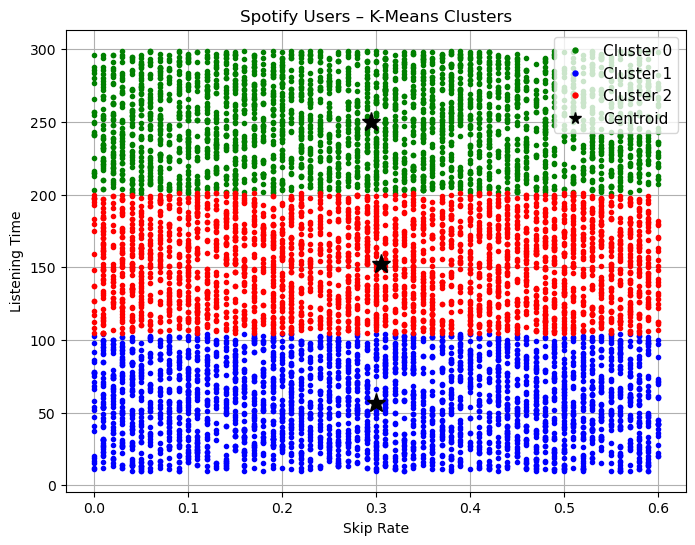

In [6]:
plt.figure(figsize=(8, 6))

colors = ['g.', 'b.', 'r.']

# plot clusters
for c in range(k):
    subset = df[df["cluster"] == c]
    plt.plot(
        subset["skip_rate"],
        subset["listening_time"],
        colors[c],
        label=f"Cluster {c}"
    )

# ---- FIX: separate centroid legend marker vs plot marker ----

# 1. Add INVISIBLE centroid marker just for the legend (small size)
plt.plot([], [], 'k*', ms=7, label="Centroid")

# 2. Plot the REAL centroids (big & visible)
for i in range(len(kmeans_spotify.centroids)):
    cx = kmeans_spotify.centroids.iloc[i]["skip_rate"]
    cy = kmeans_spotify.centroids.iloc[i]["listening_time"]
    plt.plot(cx, cy, 'k*', ms=14)   # bigger so visible on graph

# --------------------------------------------------------------

plt.xlabel("Skip Rate")
plt.ylabel("Listening Time")
plt.title("Spotify Users – K-Means Clusters")

plt.legend(markerscale=1.2, fontsize=11, frameon=True, facecolor="white")
plt.grid()
plt.show()


Calculates and visualizes the churn rate for each cluster.

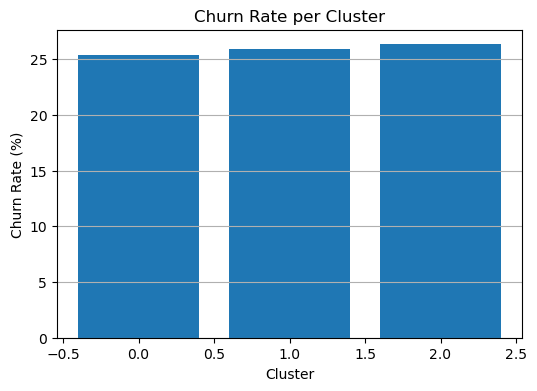

In [7]:
# churn rate per cluster
cluster_churn = df.groupby("cluster")["is_churned"].mean().reset_index()
cluster_churn["churn_rate_%"] = cluster_churn["is_churned"] * 100
cluster_churn

plt.figure(figsize=(6, 4))
plt.bar(cluster_churn["cluster"], cluster_churn["churn_rate_%"])
plt.xlabel("Cluster")
plt.ylabel("Churn Rate (%)")
plt.title("Churn Rate per Cluster")
plt.grid(axis="y")
plt.show()

### 1.5 Association Rule Mining: Understanding how skip rate relates to churn within each cluster

Prepares the data for association rule mining (ARM) within each cluster

In [8]:
cluster_rules = {}  # store rules per cluster

for c in df['cluster'].unique():
    cluster_df_arm = df[df['cluster'] == c].copy()
    
    # Binning skip_rate within this cluster
    cluster_df_arm['skip_rate_bin_fixed'] = pd.cut(
        cluster_df_arm['skip_rate'],
        bins=[0, 0.2, 1.0],
        labels=["low_skip", "higher_skip"]
    )
    
    # Convert churn boolean to label
    cluster_df_arm['churn_label'] = cluster_df_arm['is_churned'].map({True: "churn_yes", False: "churn_no"})
    
    # Drop any rows with missing bin
    cluster_df_arm = cluster_df_arm.dropna(subset=['skip_rate_bin_fixed', 'churn_label'])
    
    # Prepare transactions, convert everything to string
    transactions = cluster_df_arm.apply(
        lambda row: [str(row['skip_rate_bin_fixed']), str(row['churn_label'])],
        axis=1
    ).tolist()
    
    # One-hot encode
    te = TransactionEncoder()
    te_ary = te.fit(transactions).transform(transactions)
    arm_ohe = pd.DataFrame(te_ary, columns=te.columns_)
    
    # Store for next step
    cluster_rules[c] = arm_ohe

Displays a summary of each cluster

In [9]:
print("Cluster summaries:\n")
for c in sorted(df['cluster'].unique()):
    cluster_size = len(df[df['cluster'] == c])
    avg_skip = df[df['cluster'] == c]['skip_rate'].mean()
    churn_rate = df[df['cluster'] == c]['is_churned'].mean() * 100

    print(f"Cluster {c}:")
    print(f"  Number of users: {cluster_size}")
    print(f"  Average skip rate: {avg_skip:.2f}")
    print(f"  Churn rate: {churn_rate:.2f}%\n")


Cluster summaries:

Cluster 0:
  Number of users: 2723
  Average skip rate: 0.29
  Churn rate: 25.38%

Cluster 1:
  Number of users: 2642
  Average skip rate: 0.30
  Churn rate: 25.97%

Cluster 2:
  Number of users: 2635
  Average skip rate: 0.31
  Churn rate: 26.34%



Generates all association rules from the one-hot encoded dataset (arm_ohe_fixed) using the RuleMiner class with a minimum support and confidence threshold

In [10]:
# Generate and display all unique association rules
# Initialize RuleMiner
support_threshold = max(1, int(0.005 * len(arm_ohe)))  # 0.5% of dataset
confidence_threshold = 0.1
rule_miner = RuleMiner(support_t=support_threshold, confidence_t=confidence_threshold)

# Generate all association rules
all_rules = rule_miner.get_association_rules(arm_ohe)

# Remove duplicates
seen = set()
unique_rules = []
for rule in all_rules:
    hashable_rule = (tuple(rule[0]), tuple(rule[1]))
    if hashable_rule not in seen:
        seen.add(hashable_rule)
        unique_rules.append(rule)

# Display all unique rules
print(f"Total unique rules: {len(unique_rules)}")
display(unique_rules)

Total unique rules: 8


[(['churn_no'], ['higher_skip'], 1318, 0.6540942928039702),
 (['higher_skip'], ['churn_no'], 1318, 0.7484383872799546),
 (['churn_no'], ['low_skip'], 697, 0.34590570719602975),
 (['low_skip'], ['churn_no'], 697, 0.7414893617021276),
 (['churn_yes'], ['higher_skip'], 443, 0.6457725947521866),
 (['higher_skip'], ['churn_yes'], 443, 0.2515616127200454),
 (['churn_yes'], ['low_skip'], 243, 0.35422740524781343),
 (['low_skip'], ['churn_yes'], 243, 0.25851063829787235)]

Filters the association rules generated to focus only on patterns where skip rate bins (low_skip or higher_skip) are the antecedents and churn labels (churn_yes or churn_no) are the consequents.

In [17]:
# Define skip rate bins
skip_bins = ["low_skip", "higher_skip"]

# Filter rules where skip_rate is antecedent and churn_label is consequent
skip_to_churn_rules = [
    rule for rule in unique_rules
    if any(item in skip_bins for item in rule[0])  # antecedent contains skip_rate bin
    and any("churn" in item for item in rule[1])   # consequent contains churn label
]

# Display filtered rules
print("Filtered skip_rate → churn rules (no duplicates):")
display(skip_to_churn_rules)

print("Total filtered rules:", len(skip_to_churn_rules))

Filtered skip_rate → churn rules (no duplicates):


[(['higher_skip'], ['churn_no'], 1318, 0.7484383872799546),
 (['low_skip'], ['churn_no'], 697, 0.7414893617021276),
 (['higher_skip'], ['churn_yes'], 443, 0.2515616127200454),
 (['low_skip'], ['churn_yes'], 243, 0.25851063829787235)]

Total filtered rules: 4


Generates cluster-specific skip rate → churn association rules

In [18]:
cluster_association_rules = {}
confidence_threshold = 0.1  # 10% confidence

for c, arm_ohe in cluster_rules.items():
    # Initialize RuleMiner with support=1 (catch all)
    rule_miner = RuleMiner(support_t=1, confidence_t=confidence_threshold)
    rules = rule_miner.get_association_rules(arm_ohe)

    # Detect skip bins and churn labels in the one-hot columns
    skip_bins = [col for col in arm_ohe.columns if "skip" in col]
    churn_cols = [col for col in arm_ohe.columns if "churn" in col]

    # Filter rules: skip_rate → churn
    skip_to_churn = [
        rule for rule in rules
        if any(item in skip_bins for item in rule[0])
        and any(item in churn_cols for item in rule[1])
    ]

    # Remove duplicates 
    unique_rules = []
    seen = set()
    for rule in skip_to_churn:
        hashable_rule = (tuple(rule[0]), tuple(rule[1]))
        if hashable_rule not in seen:
            seen.add(hashable_rule)
            unique_rules.append(rule)

    cluster_association_rules[c] = unique_rules

for c in sorted(cluster_association_rules.keys()):
    rules = cluster_association_rules[c]
    print(f"\nCluster {c} rules (skip_rate → churn):")
    if rules:
        display(rules)
    else:
        print("No rules found.")


Cluster 0 rules (skip_rate → churn):


[(['higher_skip'], ['churn_no'], 1318, 0.7484383872799546),
 (['low_skip'], ['churn_no'], 697, 0.7414893617021276),
 (['higher_skip'], ['churn_yes'], 443, 0.2515616127200454),
 (['low_skip'], ['churn_yes'], 243, 0.25851063829787235)]


Cluster 1 rules (skip_rate → churn):


[(['higher_skip'], ['churn_no'], 1274, 0.7309236947791165),
 (['low_skip'], ['churn_no'], 660, 0.7551487414187643),
 (['higher_skip'], ['churn_yes'], 469, 0.26907630522088355),
 (['low_skip'], ['churn_yes'], 214, 0.2448512585812357)]


Cluster 2 rules (skip_rate → churn):


[(['higher_skip'], ['churn_no'], 1303, 0.7378255945639864),
 (['low_skip'], ['churn_no'], 626, 0.7373380447585395),
 (['higher_skip'], ['churn_yes'], 463, 0.2621744054360136),
 (['low_skip'], ['churn_yes'], 223, 0.2626619552414605)]

Computes basic metrics for each cluster’s skip rate → churn rules

In [19]:
cluster_rule_metrics = {}

for c, rules in cluster_association_rules.items():
    if rules:
        metrics = []
        for rule in rules:
            X, Y = rule[0], rule[1]
            support_XY = cluster_rules[c].loc[:, X + Y].all(axis=1).sum() / len(cluster_rules[c])
            support_X = cluster_rules[c].loc[:, X].all(axis=1).sum() / len(cluster_rules[c])
            confidence = support_XY / support_X if support_X > 0 else 0
            metrics.append({
                'antecedent': X,
                'consequent': Y,
                'support': support_XY,
                'confidence': confidence
            })
        cluster_rule_metrics[c] = pd.DataFrame(metrics)

Stores all metrics in a list of dictionaries per cluster

In [20]:
cluster_rule_metrics = {}  # store metrics per cluster

for c, rules in cluster_association_rules.items():
    metrics_list = []

    if rules:
        for rule in rules:
            X, Y = rule[0], rule[1]

            # Support(X ∪ Y)
            support_XY = cluster_rules[c].loc[:, X + Y].all(axis=1).sum() / len(cluster_rules[c])

            # Support(X) and Support(Y)
            support_X = cluster_rules[c].loc[:, X].all(axis=1).sum() / len(cluster_rules[c])
            support_Y = cluster_rules[c].loc[:, Y].all(axis=1).sum() / len(cluster_rules[c])

            # Confidence
            confidence = support_XY / support_X if support_X > 0 else 0

            # Lift
            lift = confidence / support_Y if support_Y > 0 else 0

            # Leverage
            leverage = support_XY - (support_X * support_Y)

            # Store all metrics with rule
            metrics_list.append({
                "rule": f"{' & '.join(X)} → {' & '.join(Y)}",
                "support": support_XY,
                "confidence": confidence,
                "lift": lift,
                "leverage": leverage
            })
    cluster_rule_metrics[c] = metrics_list

for c in sorted(df['cluster'].unique()):
    metrics_list = cluster_rule_metrics.get(c, [])  # get metrics or empty list if not present
    if metrics_list:
        print(f"\nCluster {c} rule metrics:")
        display(pd.DataFrame(metrics_list))
    else:
        print(f"\nCluster {c} has no rule metrics.")


Cluster 0 rule metrics:


,rule,support,confidence,lift,leverage
0,higher_skip → churn_no,0.487967,0.748438,1.003242,0.001577
1,low_skip → churn_no,0.258053,0.741489,0.993927,-0.001577
2,higher_skip → churn_yes,0.164013,0.251562,0.990478,-0.001577
3,low_skip → churn_yes,0.089967,0.258511,1.017839,0.001577



Cluster 1 rule metrics:


,rule,support,confidence,lift,leverage
0,higher_skip → churn_no,0.486817,0.730924,0.989052,-0.005388
1,low_skip → churn_no,0.252197,0.755149,1.021833,0.005388
2,higher_skip → churn_yes,0.179213,0.269076,1.031000,0.005388
3,low_skip → churn_yes,0.081773,0.244851,0.938178,-0.005388



Cluster 2 rule metrics:


,rule,support,confidence,lift,leverage
0,higher_skip → churn_no,0.498279,0.737826,1.000215,0.000107
1,low_skip → churn_no,0.239388,0.737338,0.999554,-0.000107
2,higher_skip → churn_yes,0.177055,0.262174,0.999397,-0.000107
3,low_skip → churn_yes,0.085277,0.262662,1.001255,0.000107


Visualizes the skip rate → churn association rules for each cluster using a horizontal bar chart

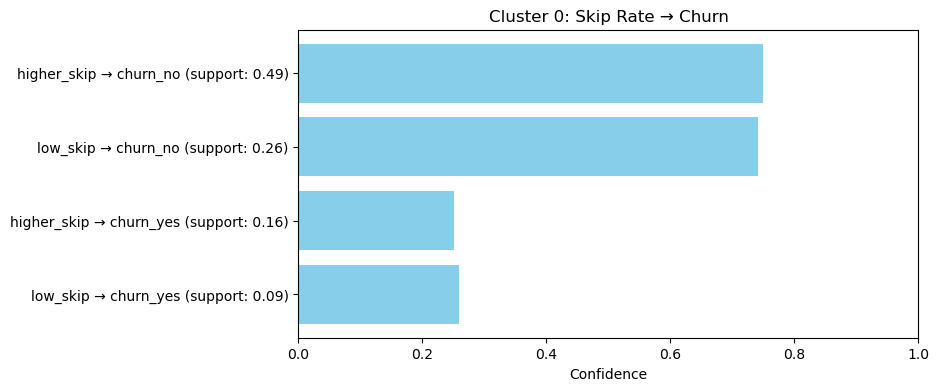

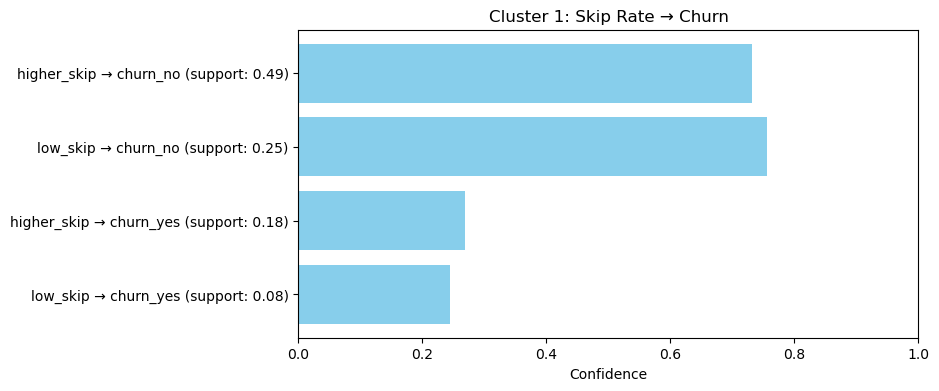

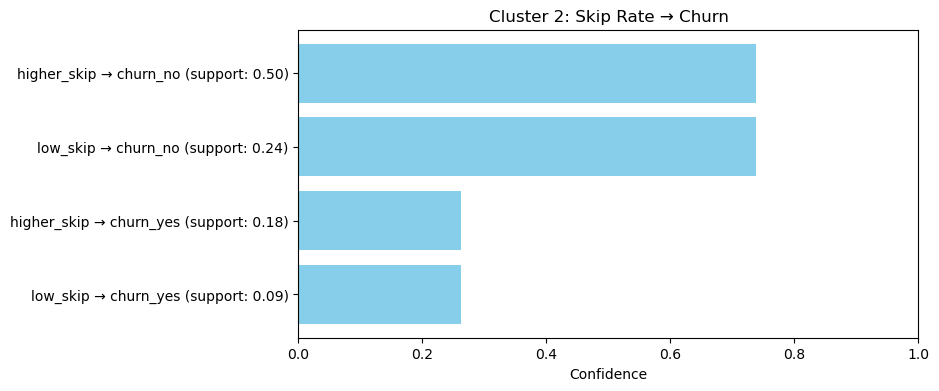

In [22]:
for c in sorted(cluster_rule_metrics.keys()):
    df_rules = pd.DataFrame(cluster_rule_metrics[c]) 

    if not df_rules.empty:
        rule_labels = [
            f"{row['rule']} (support: {row['support']:.2f})"
            for _, row in df_rules.iterrows()
        ]
        confidences = df_rules['confidence'].tolist()

        # Plot horizontal bar chart
        plt.figure(figsize=(8, 4))
        plt.barh(rule_labels, confidences, color='skyblue')
        plt.xlabel("Confidence")
        plt.title(f"Cluster {c}: Skip Rate → Churn")
        plt.xlim(0, 1)
        plt.gca().invert_yaxis()  # highest confidence on top
        plt.show()
    else:
        print(f"Cluster {c} has no skip_rate → churn rules.")

Visualizes the strength of association between skip rate and churn using lift instead of confidence

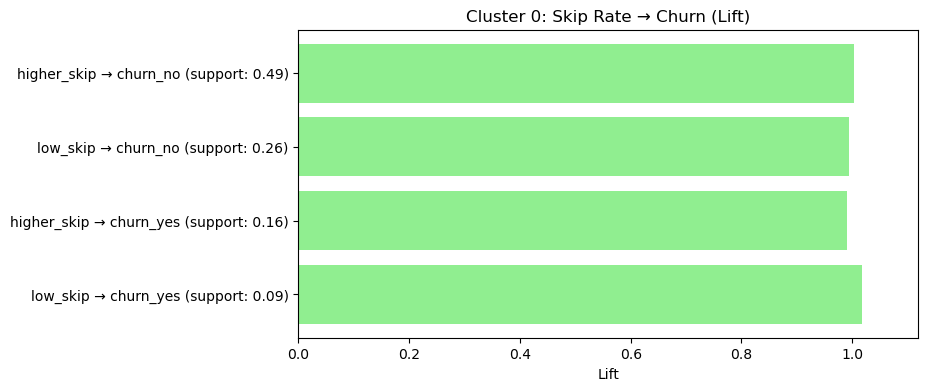

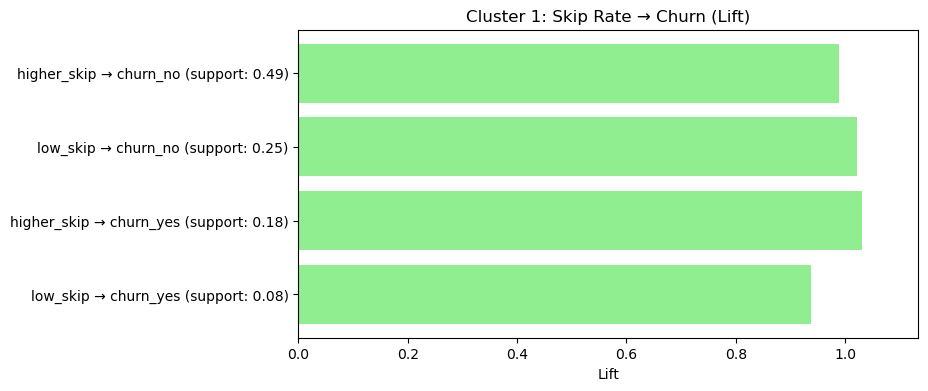

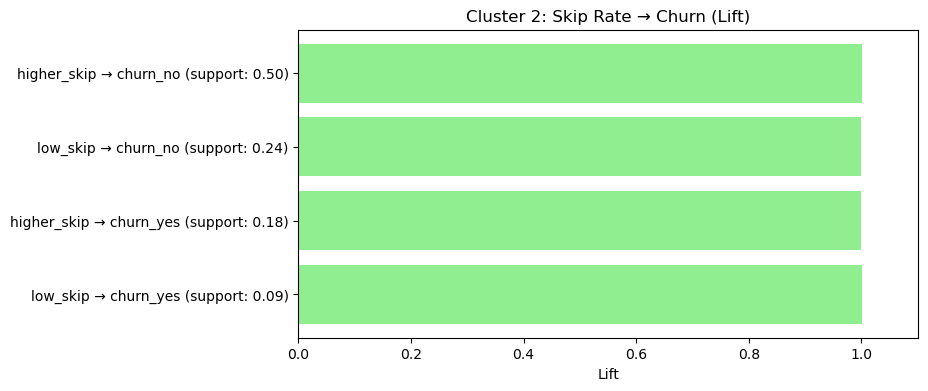

In [23]:
for c in sorted(cluster_rule_metrics.keys()):
    df_rules = pd.DataFrame(cluster_rule_metrics[c])  

    if not df_rules.empty:
        rule_labels = [
            f"{row['rule']} (support: {row['support']:.2f})"
            for _, row in df_rules.iterrows()
        ]
        lifts = df_rules['lift'].tolist()  # use lift as bar length

        # Plot horizontal bar chart
        plt.figure(figsize=(8, 4))
        plt.barh(rule_labels, lifts, color='lightgreen')
        plt.xlabel("Lift")
        plt.title(f"Cluster {c}: Skip Rate → Churn (Lift)")
        plt.xlim(0, max(lifts) * 1.1)  
        plt.gca().invert_yaxis() 
        plt.show()
    else:
        print(f"Cluster {c} has no skip_rate → churn rules to plot with lift.")

---

## 2. Statistical Inference

### 2.1 Research Question

In Phase 1 we explored association rules and binned `skip_rate` to find rules of the type `skip_* -> churn_*`. Phase 2 formally tests whether `skip_rate` differs between churned and non-churned users and whether categorical skip behavior is associated with churn.

Association Rule Mining: attempted to uncover rules of the form skip_* → churn_*, but produced weak or sparse rules. This indicates that skip-related behaviors do not form strong categorical patterns leading directly to churn. Because ARM is sensitive to discretization and support thresholds, its inconclusive result suggests that a more rigorous, continuous-variable statistical approach is necessary to confirm whether skip_rate truly relates to churn.

KMeans Clustering: clustering segmented users based on multiple behavioral features, but skip_rate did not emerge as a dominant driver separating churned from non-churned users. While some clusters displayed higher average skip behavior alongside elevated churn rates, the clustering model did not provide statistical evidence of a meaningful difference—only descriptive patterns.

Together, these modeling observations justify the need for statistical inference. Modeling alone cannot establish significance; therefore, hypothesis testing is required to formally determine whether skip_rate differs between churn groups and whether any observed differences are statistically reliable rather than incidental.

### 2.2 Hypotheses

**Mean comparison tests (t-test, z-test, ANOVA)**

- **H₀:** μ_skip_rate(churn = 1) = μ_skip_rate(churn = 0)  
- **H₁:** μ_skip_rate(churn = 1) ≠ μ_skip_rate(churn = 0)

**Chi-square test (categorical association)**

- **H₀:** skip_rate category is independent of churn  
- **H₁:** skip_rate category is associated with churn

**Significance level:** α = 0.05

### 2.3 Preprocessing Steps

In [24]:
# Cell: Imports and data load
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.weightstats import ztest as ztest_mean
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway
from scipy.stats import levene

# Load only the columns we need for Phase 2
df = pd.read_csv("spotify_churn_dataset.csv")
print("Loaded dataset shape:", df.shape)
print("Columns:", list(df.columns))

# Preview
display(df[['skip_rate','is_churned']].head())

Loaded dataset shape: (8000, 12)
Columns: ['user_id', 'gender', 'age', 'country', 'subscription_type', 'listening_time', 'songs_played_per_day', 'skip_rate', 'device_type', 'ads_listened_per_week', 'offline_listening', 'is_churned']


,skip_rate,is_churned
0,0.20,1
1,0.34,0
2,0.04,1
3,0.31,0
4,0.36,1


In [25]:
# Cell: Preprocessing (explicit steps shown)
# 1) Check for the presence of required columns
required_cols = ['skip_rate','is_churned']
for c in required_cols:
    if c not in df.columns:
        raise ValueError(f"Required column '{c}' not found in dataset")

# 2) Handle types and missing values
# Convert is_churned to numeric 0/1 if needed
if df['is_churned'].dtype == 'bool':
    df['is_churned'] = df['is_churned'].astype(int)
elif df['is_churned'].dtype == object:
    # common mappings (adjust if your notebook uses different labels)
    map_dict = {'yes':1,'no':0,'True':1,'False':0}
    df['is_churned'] = df['is_churned'].map(map_dict).fillna(df['is_churned'])
    if df['is_churned'].dtype == object:
        df['is_churned'] = pd.to_numeric(df['is_churned'], errors='coerce')

before_n = df.shape[0]
# Drop rows missing either variable
df = df.dropna(subset=['skip_rate','is_churned']).copy()
after_n = df.shape[0]
print(f"Dropped {before_n-after_n} rows with missing skip_rate or is_churned. Remaining rows: {after_n}")

# 3) Ensure skip_rate scale is 0-1 (proportion)
# If max > 1, assume percentage (0-100) and convert
sr_max = df['skip_rate'].astype(float).max()
print("skip_rate max value:", sr_max)
if sr_max > 1.0:
    print("Converting skip_rate from percentage (0-100) to proportion (0-1).")
    df['skip_rate'] = df['skip_rate'].astype(float) / 100.0
else:
    df['skip_rate'] = df['skip_rate'].astype(float)

# 4) Create the two groups for testing
group_non = df[df['is_churned'] == 0]['skip_rate'].reset_index(drop=True)
group_churn = df[df['is_churned'] == 1]['skip_rate'].reset_index(drop=True)
n0, n1 = len(group_non), len(group_churn)
print(f"n_non_churn = {n0}, n_churn = {n1}")
print("Mean skip_rate (non-churn) = {:.6f}".format(group_non.mean()))
print("Mean skip_rate (churn)     = {:.6f}".format(group_churn.mean()))


Dropped 0 rows with missing skip_rate or is_churned. Remaining rows: 8000
skip_rate max value: 0.6
n_non_churn = 5929, n_churn = 2071
Mean skip_rate (non-churn) = 0.298474
Mean skip_rate (churn)     = 0.304862


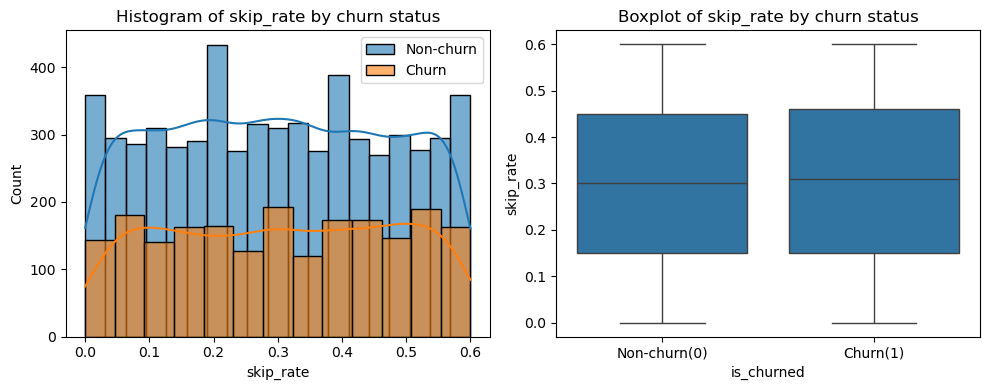

In [26]:
# Cell: Visual checks (useful for report)
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.histplot(group_non, kde=True, label='Non-churn', alpha=0.6)
sns.histplot(group_churn, kde=True, label='Churn', alpha=0.6)
plt.legend()
plt.title('Histogram of skip_rate by churn status')

plt.subplot(1,2,2)
sns.boxplot(x='is_churned', y='skip_rate', data=df)
plt.xticks([0,1], ['Non-churn(0)', 'Churn(1)'])
plt.title('Boxplot of skip_rate by churn status')
plt.tight_layout()
plt.show()


In [27]:
# Cell: Assumptions & variance checks
alpha = 0.05
# Normality: Shapiro (note: Shapiro sensitive for large n; if n>5000 we may skip or sample)
shap_p0 = None
shap_p1 = None
try:
    if n0 <= 5000:
        shap_p0 = stats.shapiro(group_non.sample(min(n0,5000), random_state=1))[1]
    if n1 <= 5000:
        shap_p1 = stats.shapiro(group_churn.sample(min(n1,5000), random_state=1))[1]
except Exception as e:
    print("Shapiro test skipped/error:", e)

print("Approx Shapiro p-values (non-churn, churn):", shap_p0, shap_p1)

# Levene's test for equality of variances (robust)
levene_stat, levene_p = stats.levene(group_non, group_churn, center='median')
print("Levene test: stat={:.4f}, p={:.4e}".format(levene_stat, levene_p))
equal_var = (levene_p >= alpha)
print("Assume equal variances for t-test?" , equal_var)


Approx Shapiro p-values (non-churn, churn): None 1.408665895161061e-25
Levene test: stat=0.5074, p=4.7627e-01
Assume equal variances for t-test? True


### 2.4 Inference Proper

*A. Z-Test for Difference in Mean Skip Rates (Large-Sample Robustness Check)*

In [28]:
# Cell: z-test (large-sample approx for difference in means)
# This is a robustness check: with large samples z-test should be similar to t-test.
try:
    z_stat, z_p = ztest_mean(group_churn, group_non, alternative='two-sided', usevar='unequal')
    print("Z-test (two-sided): z = {:.6f}, p = {:.6e}".format(z_stat, z_p))
    if z_p < alpha:
        print("Result: Reject H0 (z-test).")
    else:
        print("Result: Fail to reject H0 (z-test).")
except Exception as e:
    print("Z-test not performed:", e)

Z-test (two-sided): z = 1.438017, p = 1.504293e-01
Result: Fail to reject H0 (z-test).


The z-test showed no statistically significant difference in mean skip_rate between churned and non-churned users (p ≈ 0.15 > 0.05).
This indicates that skip_rate does not differ meaningfully between the two groups when evaluated with large-sample normal approximations.

*B. Two-Sample t-Test for Difference in Mean Skip Rates*

In [29]:
# Cell: Two-sample t-test (means comparison)
t_stat, t_p = stats.ttest_ind(group_churn, group_non, equal_var=equal_var, nan_policy='omit')
print("Two-sample t-test (two-sided):")
print("H0: mean(skip_rate | churn=1) == mean(skip_rate | churn=0)")
print("t-statistic = {:.6f}, p-value = {:.6e}, alpha = {:.2f}".format(t_stat, t_p, alpha))
if t_p < alpha:
    print("Result: Reject H0 (significant difference in means).")
else:
    print("Result: Fail to reject H0 (no significant difference in means).")


Two-sample t-test (two-sided):
H0: mean(skip_rate | churn=1) == mean(skip_rate | churn=0)
t-statistic = 1.441943, p-value = 1.493577e-01, alpha = 0.05
Result: Fail to reject H0 (no significant difference in means).


Consistent with the z-test, the independent t-test also found no significant difference in mean skip_rate between churn and non-churn groups (p ≈ 0.149 > 0.05).
Thus, the difference in average skip_rate is not statistically reliable.

*C. Two-Sample t-Test: Testing Whether Mean Skip Rates Differ Between Churn Groups*

In [30]:
# Cell: Chi-square test (after binning skip_rate into terciles)
# This tests association between categorical skip behavior and churn.
df['skip_cat'] = pd.qcut(df['skip_rate'], q=3, labels=['low','mid','high'])
contingency = pd.crosstab(df['skip_cat'], df['is_churned'])
chi2_stat, chi2_p, chi2_dof, chi2_expected = stats.chi2_contingency(contingency)
print("Chi-square test (skip_cat vs is_churned):")
print("Contingency table:\n", contingency)
print("chi2 = {:.6f}, p-value = {:.6e}, dof = {}".format(chi2_stat, chi2_p, chi2_dof))
if chi2_p < alpha:
    print("Result: Reject H0 — skip_rate category associated with churn.")
else:
    print("Result: Fail to reject H0 — no association detected.")


Chi-square test (skip_cat vs is_churned):
Contingency table:
 is_churned     0    1
skip_cat             
low         2034  696
mid         1996  676
high        1899  699
chi2 = 2.104229, p-value = 3.491986e-01, dof = 2
Result: Fail to reject H0 — no association detected.


The chi-square test on skip_rate categories (low/mid/high) and churn status produced a non-significant result (p ≈ 0.349 > 0.05).
This means skip behavior categories are not associated with churn—users with higher skip_rate proportions do not churn at significantly different rates than others.

D. *One-way ANOVA: skip_rate across churn groups*

In [31]:
# Cell: One-way ANOVA (skip_rate by churn group)
# This formally tests whether the mean skip_rate differs between churned and non-churned users.
# Equivalent to a two-sample t-test with two groups; generalizes if more groups were present.
anova_F, anova_p = stats.f_oneway(group_non, group_churn)
print("One-way ANOVA F-statistic: {:.4f}".format(anova_F))
print("One-way ANOVA p-value: {:.4e}".format(anova_p))
if anova_p < alpha:
    print("Result: Reject H0 — mean skip_rate differs between churn groups.")
else:
    print("Result: Fail to reject H0 — no significant mean difference detected.")


One-way ANOVA F-statistic: 2.0792
One-way ANOVA p-value: 1.4936e-01
Result: Fail to reject H0 — no significant mean difference detected.


Testing skip_rate across churn groups via ANOVA yielded a non-significant p-value (≈ 0.149).
ANOVA therefore supports the t-test and z-test conclusion:
skip_rate means do not differ significantly between churn groups.

 E. *Test of Variances: Comparing Skip Rate Variance Between Churn Groups*

In [32]:
# Cell: Tests of variance equality (Levene's and F-test)
# These tests determine whether skip_rate variance is equal between churned and non-churned groups.
# Levene's test is robust to non-normality; the F-test ratio directly compares variances.
levene_stat, levene_p = stats.levene(group_non, group_churn, center='median')
var_non = group_non.var(ddof=1)
var_churn = group_churn.var(ddof=1)
f_ratio = var_non / var_churn
print("Levene test: stat={:.4f}, p={:.4e}".format(levene_stat, levene_p))
if levene_p < alpha:
    print("Result: Reject H0 — variances significantly differ.")
else:
    print("Result: Fail to reject H0 — no significant variance difference detected.")
print("F-test variance ratio: {:.4f}".format(f_ratio))
print("Variance (non-churn): {:.6f}".format(var_non))
print("Variance (churn): {:.6f}".format(var_churn))


Levene test: stat=0.5074, p=4.7627e-01
Result: Fail to reject H0 — no significant variance difference detected.
F-test variance ratio: 0.9888
Variance (non-churn): 0.030042
Variance (churn): 0.030384


Levene’s test showed no significant difference in variance (p ≈ 0.476 > 0.05).
This indicates churned and non-churned users exhibit similar spread and variability in skip_rate.
The F-test supports this, with almost identical variances (0.03004 vs 0.03038).

## 3. Conclusion


*What is the relationship between a user's skip_rate and the likelihood of customer churn?*

The association rules show that both high and low skip rates are nearly equally likely to lead to either churn or retention. Among most clusters, the analysis revealed the lack of a strong association between the user's skip rate and their decision to churn. For most users (Clusters 0 and 2), the Lift analysis showed no meaningful relationship, with skip rate being a neutral behavior. However, Cluster 1's lift analysis showed that a high skip rate increases churn likelihood, while a low skip rate decreases it. This displayed that skip rate is not a universal churn indicator, but can be a predictor for a specific, vulnerable segment.